## Basic Neo4J Queries

In this notebook we are going to play with basic CYPHER queries.

1. [Connecting with Neo4J server](neo4j_connect)


In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [4]:
# Get the Neo4j Driver
from neo4j import GraphDatabase
driver = GraphDatabase.driver('bolt://localhost:7687', auth=("neo4j", "erad_db"))

In [36]:
# Let's get the buses and power network
def run_cypher_query(query):
    with driver.session() as session:
        result = session.read_transaction(lambda tx: tx.run(query).data())
    return result

In [41]:
# Let's create a networkx representation to perform
# multiple source multiple sink max flow problem
# https://faculty.math.illinois.edu/~mlavrov/docs/482-fall-2019/lecture27.pdf 
import networkx as nx

def create_undirected_graph(
    list_of_rels, 
    sourceNode='sourceNode', 
    targetNode='targetNode',  ):
    """ Creates a undirected graph from the Cypher query results """
    
    graph = nx.Graph()
    for rel in list_of_rels:
        
        # Unpack the relationship data
        relationship = rel['relationship']
        source_node = rel['sourceNode']
        target_node = rel['targetNode']
        
        # Add nodes if not already present in the graph
        for node in [source_node, target_node]:
            if not graph.has_node(node['name']):
                graph.add_node(node['name'], **node)
        
        # Add relationship
        graph.add_edge(source_node['name'], target_node['name'], **relationship)
        
    return graph

In [46]:
# Get the buses, customers, pvs, energystorage and line sections
power_network_query = """
MATCH (sourceNode:Bus)-[relationship:CONNECTS_TO]-(targetNode:Bus)
return relationship{.*} , sourceNode {.*}, targetNode{.*}
"""

# Gettings relations between customers and buses
customer_bus_network_query = """
MATCH (sourceNode:Bus)-[relationship:CONSUMES_POWER]-(targetNode:Customer)
return relationship{.*} , sourceNode {.*}, targetNode{.*}
"""

# Gettting relations between PVs and buses
pv_bus_network_query = """
MATCH (sourceNode:Bus)-[relationship:INJECTS_ACTIVE_POWER_TO]-(targetNode:Solar)
return relationship{.*} , sourceNode {.*}, targetNode{.*}
"""

# Getting relations between energy storage and buses
es_bus_network_query = """
MATCH (sourceNode:Bus)-[relationship:INJECTS_POWER]-(targetNode:EnergyStorage)
return relationship{.*} , sourceNode {.*}, targetNode{.*}
"""

relations = []
for query in [power_network_query, customer_bus_network_query,
             pv_bus_network_query, es_bus_network_query]:
    relations.extend(run_cypher_query(query))

graph = create_undirected_graph(relations)
d_graph = graph.to_directed()

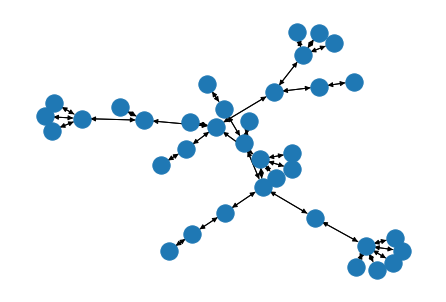

In [48]:
# Visualize the directed graph 
import matplotlib.pyplot as plt
nx.draw(d_graph)
plt.show()

In [66]:
# Let's update the edge property with capacity
node_data = {item[0]:item[1] for item in d_graph.nodes(data=True)}
for edge in d_graph.edges():
    edge_data = d_graph.edges[edge[0], edge[1]]
    
    # If an edge is connecting to load we are setting capacity limit to be load kw
    # Assuming unity power factor
    
    for node in [edge[0], edge[1]]:
        if 'load' in node_data[node]['name']:
            d_graph.edges[edge[0], edge[1]]['capacity'] = float(node_data[node]['kw'])
        
        if 'pv' in node_data[node]['name']:
            d_graph.edges[edge[0], edge[1]]['capacity'] = float(node_data[node]['capacity'])
            
        if 'es_' in node_data[node]['name']:
            d_graph.edges[edge[0], edge[1]]['capacity'] = float(node_data[node]['kw'])
    
    # If a edge has ampacity relation we are converting to kva
    if 'ampacity' in edge_data:
        d_graph.edges[edge[0], edge[1]]['capacity'] = float(edge_data['ampacity'])*1.731*0.4
        
    # If a edge has kva directly use that
    if 'kva' in edge_data:
        d_graph.edges[edge[0], edge[1]]['capacity'] = float(edge_data['kva'])
    
    # If a source node is connecting the edge we are setting it to 500 
    if 'sourcebus' in [edge[0], edge[1]]:
          d_graph.edges[edge[0], edge[1]]['capacity'] = 500

In [68]:
# Now let's see if we can find max flow from source node to one of the load node
flow_value, flow_dict = nx.maximum_flow(d_graph, 'sourcebus', 'load.675a')
print(flow_value, flow_dict)

117.0 {'sourcebus': {'650': 117.0}, '650': {'sourcebus': 0, 'rg60': 117.0}, 'rg60': {'650': 0, '632': 117.0}, '632': {'rg60': 0, '633': 0, '645': 0, '670': 117.0}, '633': {'634': 0, '632': 0}, '634': {'633': 0, 'load.634a': 0, 'load.634b': 0, 'load.634c': 0, 'pv_634b': 0, 'es_634b': 0}, '671': {'692': 117.0, '684': 0, '680': 0, '670': 0, 'load.671': 0}, '692': {'671': 0, '675': 117.0, 'load.692': 0}, '684': {'671': 0, '611': 0, '652': 0}, '680': {'671': 0, 'pv_680': 0}, '670': {'671': 117.0, '632': 0, 'load.670a': 0, 'load.670b': 0, 'load.670c': 0}, '645': {'646': 0, '632': 0, 'load.645': 0}, '646': {'645': 0, 'load.646': 0}, '675': {'692': 0, 'load.675a': 117.0, 'load.675b': 0, 'load.675c': 0}, '611': {'684': 0, 'load.611': 0, 'pv_611': 0, 'es_611': 0}, '652': {'684': 0, 'load.652': 0}, 'load.671': {'671': 0}, 'load.634a': {'634': 0}, 'load.634b': {'634': 0}, 'load.634c': {'634': 0}, 'load.645': {'645': 0}, 'load.646': {'646': 0}, 'load.692': {'692': 0}, 'load.675a': {'675': 0}, 'load

In [74]:
# Let's solve the problem associated with multiple source and multiple sinks
# In this test data we have 3 pv system with total capacity of 360 kW
# 2 energy storage of 40 kW, total load of 1755 kW 
# Let's figure out the maximum flow possible from energy sources to sink
# Ideally if the network has enough capacity this should be 360 + 40 = 400

# Before we do this we need to create an infinity source and infinity sink and connect 
# sources and sinks together
for new_node in ['infinity_source', 'infinity_sink']:
    if not d_graph.has_node(new_node):
        d_graph.add_node(new_node)

# Let's connect sources and sinks
for node in d_graph.nodes():
    # Connect all loads to infinity sink
    if 'load.' in node:
        d_graph.add_edge(node, 'infinity_sink', capacity=2000)
        d_graph.add_edge('infinity_sink', node,  capacity=2000)
        
    if 'pv' in node or 'es_' in node:
        d_graph.add_edge(node, 'infinity_source', capacity=2000)
        d_graph.add_edge('infinity_source', node, capacity=2000)

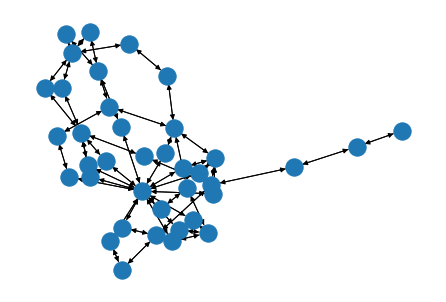

In [76]:
# Visualize the directed graph 
import matplotlib.pyplot as plt
nx.draw(d_graph)
plt.show()

In [78]:
# Now let's see if we can find max flow from source node to one of the load node
flow_value, flow_dict = nx.maximum_flow(d_graph, 'infinity_source', 'infinity_sink')
print(flow_value, flow_dict)

376.96000000000004 {'sourcebus': {'650': 0}, '650': {'sourcebus': 0, 'rg60': 0}, 'rg60': {'650': 0, '632': 0}, '632': {'rg60': 0, '633': 0, '645': 0, '670': 0}, '633': {'634': 0, '632': 0}, '634': {'633': 0, 'load.634a': 50.0, 'load.634b': 0, 'load.634c': 0, 'pv_634b': 0, 'es_634b': 0}, '671': {'692': 159.96000000000004, '684': 0, '680': 0, '670': 0, 'load.671': 117.0}, '692': {'671': 0, '675': 42.960000000000036, 'load.692': 117.0}, '684': {'671': 0, '611': 0, '652': 0}, '680': {'671': 276.96000000000004, 'pv_680': 0}, '670': {'671': 0, '632': 0, 'load.670a': 0, 'load.670b': 0, 'load.670c': 0}, '645': {'646': 0, '632': 0, 'load.645': 0}, '646': {'645': 0, 'load.646': 0}, '675': {'692': 0, 'load.675a': 42.960000000000036, 'load.675b': 0, 'load.675c': 0}, '611': {'684': 0, 'load.611': 50.0, 'pv_611': 0, 'es_611': 0}, '652': {'684': 0, 'load.652': 0}, 'load.671': {'671': 0, 'infinity_sink': 117.0}, 'load.634a': {'634': 0, 'infinity_sink': 50.0}, 'load.634b': {'634': 0, 'infinity_sink': 0